## Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline


## Load Data

In [3]:
data_path = '../IDMT-Traffic/datasets/df_main_encoded_only.csv'  
df = pd.read_csv(data_path)
df = df.drop(columns=['file', 'Unnamed: 0', 'is_background_encoded'])
print(df.head(2))


   date_time_encoded  location_encoded  speed_kmh_encoded  daytime_encoded  \
0                  0                 0                  0                1   
1                  0                 0                  0                1   

   weather_encoded  vehicle_encoded  source_direction_encoded  \
0                0                1                         1   
1                0                1                         1   

   microphone_encoded  channel_encoded     mfcc_1  ...  band_27_dB  \
0                   0                0  55.967507  ...   37.024301   
1                   1                1  52.986820  ...   34.516289   

   band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  peak_dB_2  peak_freq_2  \
0   38.508511   35.946349  50.180933    31.622777  49.528332  1000.000000   
1   34.960402   33.187933  54.903541  1000.000000  53.196406   794.328235   

   peak_dB_3  peak_freq_3  octband_dB_mean  
0  47.901831   794.328235        42.383307  
1  51.942355   501.187234        42.

## Data Initialization & Split (Test/Train)

In [4]:
# set target
target = 'daytime_encoded'  # Zielvariable
X = df.drop(columns=[target])  # Features (alle Spalten außer 'daytime')
y = df[target]  # Zielvariable

# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ausgabe der Größen
print(f"Trainingsdaten: {X_train.shape}, Testdaten: {X_test.shape}")


# 1st split: train/ test 
#X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 2nd split: train / validation 
#X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full)
# TRAIN 60% VAL 20% TEST 20%
#print(f"Trainingsdaten: {X_train.shape}, Validierungsdaten: {X_val.shape}, Testdaten: {X_test.shape}")
# standardize data
#scaler = StandardScaler() 
#X_filtered_scaled = scaler.fit_transform(X)

Trainingsdaten: (6552, 57), Testdaten: (2809, 57)


## Baseline Approach

In [5]:
# initialize model
logreg = LogisticRegression(max_iter=1000, random_state=42) # C=2

# Train model
logreg.fit(X_train, y_train)

# results
y_pred = logreg.predict(X_test)

target_names = ['A', 'M']

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*80)

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names= target_names))
print('-'*80)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print('-'*80)

Accuracy: 0.9024563901744393
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.90      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.90      0.90      0.90      2809

--------------------------------------------------------------------------------

Confusion Matrix:
 [[1525  117]
 [ 157 1010]]
--------------------------------------------------------------------------------


c:\Users\Anton\anaconda3\envs\traffic_noise\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline of LogReg shows that model should be suitable, accuracy value seems normal. Model can be further optimized. Test for overfitting.

## Pipeline with Scaler, Cross Validation 

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Schritt 1: Standardisierung
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Schritt 2: Modell
])

# Cross-Validation auf den Trainingsdaten
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Pipeline trainieren auf dem gesamten Training-Set
pipeline.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred = pipeline.predict(X_test)

# Ergebnisse ausgeben
target_names = ['A', 'M']
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("\nTestdaten-Auswertung:")
print(classification_report(y_test, y_pred, target_names= target_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Cross-Validation Accuracy Scores: [0.90465294 0.91380625 0.89389313 0.90152672 0.90916031]
Mean CV Accuracy: 0.9046078688257317

Testdaten-Auswertung:
              precision    recall  f1-score   support

           A       0.91      0.93      0.92      1642
           M       0.90      0.87      0.88      1167

    accuracy                           0.91      2809
   macro avg       0.90      0.90      0.90      2809
weighted avg       0.91      0.91      0.91      2809


Confusion Matrix:
 [[1525  117]
 [ 149 1018]]


Cross validation accuracy is close to test accuracy, which indicates no overfitting.

### Learning Curve Approach 

In [7]:
# Learning Curve berechnen
train_sizes, train_scores, val_scores = learning_curve(
    logreg,             # Dein Modell
    X_train,            # Trainingsdaten
    y_train,            # Zielvariable
    cv=5,               # Anzahl der Folds für Cross-Validation
    scoring="accuracy", # Metrik zur Bewertung
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 Stufen von 10% bis 100% der Trainingsdaten
    n_jobs=-1           # Parallelisierung für schnellere Berechnung
)

# Mittelwerte und Standardabweichungen der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


### Learning Curve Visualisation

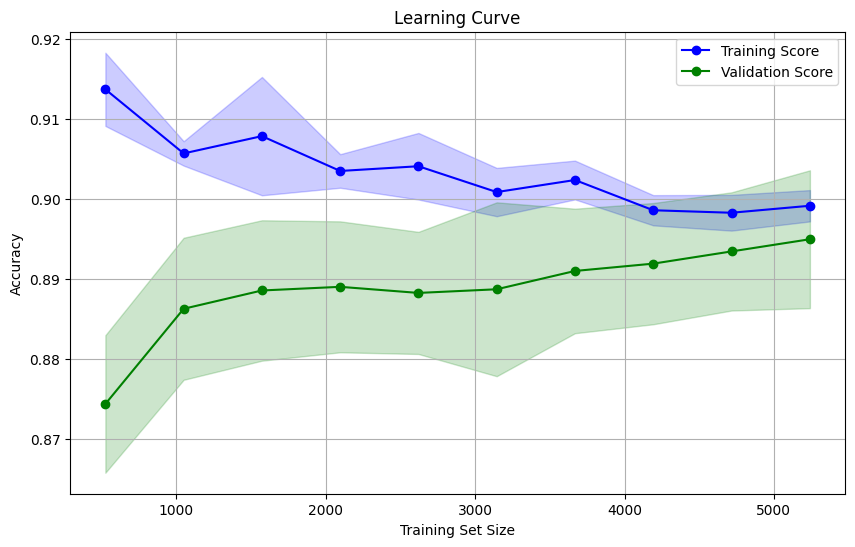

In [8]:
# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation Score")

# Fülle die Bereiche für Standardabweichung
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

# Plot-Konfiguration
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


The learning curve shows that the model suffers neither from overfitting nor from severe underfitting. It generalizes well, as the training and validation scores converge as the amount of data increases.